# IMDB 5000 Movie Dataset Clustering

===========================================================================================================

**AUTHOR**: Mengshan Jin

**CREATION DATE**: 08/03/2017

===========================================================================================================

**PROGRAM DESCRIPTION**: Clustering on the movies using the codified data only

**INPUT DATASETS**: 01_Data/Outputs/imdb_modern_cleaned.csv

**OUTPUT DATASETS**: 

**SCOPE**: 1980-2016 English movies

===========================================================================================================

**PROGRAM CHANGE HISTORY**

Date|Author|Change|
----|------|------|

# Section 0: Import packages

In [1]:
# Data structure
import numpy as np
import pandas as pd
np.random.seed(7)
# pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# utilities
import copy

# sklearn
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.externals import joblib

# Section 1: Read data

In [2]:
imdb_modern_cleaned = pd.read_csv("../../01_Data/Outputs/imdb_modern_cleaned.csv", index_col=0)

In [21]:
# check duplicates
imdb_modern_cleaned.duplicated().sum() # No duplicates

0

In [3]:
imdb_modern_cleaned.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,content_rating_G,content_rating_NC-17,content_rating_PG,content_rating_PG-13,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204.0,4834.0,0.0,3054.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Pirates of the Caribbean: At World's End,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220.0,48350.0,0.0,1238.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Spectre,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868.0,11700.0,1.0,994.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dark Knight Rises,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337.0,106759.0,0.0,2701.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
John Carter,462.0,132.0,475.0,530.0,640.0,73058679.0,212204.0,1873.0,1.0,738.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
imdb_modern_cleaned.shape

(4301, 255)

In [8]:
imdb_modern_cleaned.columns.tolist()

['num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western',
 'keyword_love',
 'keyword_friend',
 'keyword_murder',
 'keyword_death',
 'keyword_police',
 'keyword_new york city',
 'keyword_high school',
 'keyword_alien',
 'keyword_fbi',
 'keyword_boy',
 'keyword_school',
 'keyword_drugs',
 'keyword_revenge',
 'keyword_friendship',
 'keyword_prison',
 'keyword_marriage',
 'keyword_dog',
 'keyword_party',
 'keyword_sex',
 'keyword_island',
 'keyword_bo

# Section 2: Clustering

## Step 1: Split the dataset into training and out-of-time sample testing datasets

In [3]:
imdb_train = imdb_modern_cleaned.loc[imdb_modern_cleaned['title_year'] < 2015]
imdb_test = imdb_modern_cleaned.loc[imdb_modern_cleaned['title_year'] >= 2015]

In [4]:
imdb_train.shape

(4000, 255)

In [5]:
imdb_test.shape

(301, 255)

## Step 2: Training and validation on the training dataset 
Then I can choose the best clustering algorithm to build a prediction algorithm(multi-class classification problem) on top of it

### ==>Question<==
**How to measure the goodness of the clustering results?**

Two things that I care:
1. imdb_score
2. num_critic_for_reviews

Assumptions:
1. The movies that I like usually have higher imdb_score
2. The movies that I like usually have more num_critic_for_reviews

Define metric ***weighted harmonic mean of imdb_score and num_critic_for_reviews*** as follows:
1. Standardization: convert each measure to 0-1 range by calculating $\frac{x-min}{max-min}$
2. Calculate the weighted harmonic mean of the standardized measures: $\frac{1}{\frac{0.7}{p}+\frac{0.3}{q}}$

Define metric ***deviance*** to be used to measure the goodness of clustering as follows:
1. For each cluster, calculate the above metric for each movie
2. Calculate the average of the metric for each cluster: $m_1, m_2, ..., m_n$
3. Calculate the deviance among different clusters: $\sqrt{\frac{\sum_{i=1}^{n}{(m_i-\bar{m})^2}}{n}}$

To choose the best clustering method and the best parameters $\iff$ Maximizing the deviance, which means that the method can best differentiate the good movies and the bad movies

### Utility functions

In [6]:
def standardized_measure(df, col):
    return (df[col] - df[col].min())/(df[col].max() - df[col].min())

In [7]:
def harmonic_mean(row):
    try:
        return 1/(0.7*row[0]+0.3*row[1])
    except ZeroDivisionError:
        return np.nan

In [8]:
def goodness_deviance(list_num):
    num_avg = np.mean(list_num)
    return np.sqrt(np.sum([(item-num_avg)**2 for item in list_num])/len(list_num))

### KMeans

In [60]:
pipe_kmeans = Pipeline([('clustering', KMeans(n_jobs=-1))])
param_grid_kmeans = {'clustering__n_clusters':np.arange(5,31).tolist()}
param_grid_kmeans = list(ParameterGrid(param_grid_kmeans))

In [61]:
# write my own loop function to select the best parameter
best_i = -1
best_dev = 0
res_dict = {}
for i in range(len(param_grid_kmeans)):
    cluster_model = pipe_kmeans.set_params(**param_grid_kmeans[i])
    cluster_pred = cluster_model.fit_predict(imdb_train)
    tmp = pd.concat([imdb_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                     pd.Series(cluster_pred, name="cluster_num")], axis=1)
    tmp['imdb_score'] = standardized_measure(tmp, 'imdb_score')
    tmp['num_critic_for_reviews'] = standardized_measure(tmp, 'num_critic_for_reviews')
    tmp['harmonic_mean'] = tmp[['imdb_score', 'num_critic_for_reviews']].apply(harmonic_mean, axis = 1)
    tmp_gp = tmp.groupby('cluster_num').aggregate({'harmonic_mean':np.mean})
    curr_dev = goodness_deviance(tmp_gp['harmonic_mean'])
    res_dict[i] = [param_grid_kmeans[i], {"Deviance":curr_dev}]
    if curr_dev > best_dev:
        best_dev = curr_dev
        best_i = i
print "Best parameters combination:", param_grid_kmeans[best_i], "\nDeviance:", best_dev

Best parameters combination: {'clustering__n_clusters': 12} 
Deviance: 0.393123104617


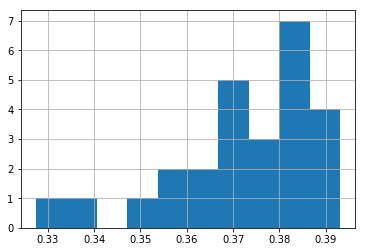

In [62]:
# check deviance distribution
lrs = [value[1]['Deviance'] for value in res_dict.values()]
pd.Series(lrs).hist()

### Agglomerative Clustering

In [63]:
pipe_agglo = Pipeline([('clustering', AgglomerativeClustering())])
param_grid_agglo = {'clustering__n_clusters':np.arange(5,31).tolist()}
param_grid_agglo = list(ParameterGrid(param_grid_agglo))

In [64]:
# write my own loop function to select the best parameter
best_i2 = -1
best_dev2 = 0
res_dict2 = {}
for i in range(len(param_grid_agglo)):
    cluster_model = pipe_agglo.set_params(**param_grid_agglo[i])
    cluster_pred = cluster_model.fit_predict(imdb_train)
    tmp = pd.concat([imdb_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                     pd.Series(cluster_pred, name="cluster_num")], axis=1)
    tmp['imdb_score'] = standardized_measure(tmp, 'imdb_score')
    tmp['num_critic_for_reviews'] = standardized_measure(tmp, 'num_critic_for_reviews')
    tmp['harmonic_mean'] = tmp[['imdb_score', 'num_critic_for_reviews']].apply(harmonic_mean, axis = 1)
    tmp_gp = tmp.groupby('cluster_num').aggregate({'harmonic_mean':np.mean})
    curr_dev = goodness_deviance(tmp_gp['harmonic_mean'])
    res_dict2[i] = [param_grid_agglo[i], {"Deviance":curr_dev}]
    if curr_dev > best_dev2:
        best_dev2 = curr_dev
        best_i2 = i
print "Best parameters combination:", param_grid_agglo[best_i2], "\nDeviance:", best_dev2

Best parameters combination: {'clustering__n_clusters': 8} 
Deviance: 0.401955602208


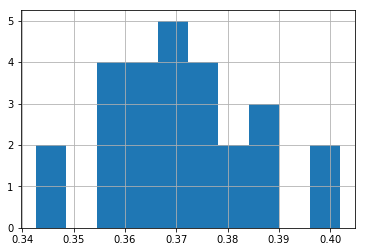

In [65]:
# check deviance distribution
lrs2 = [value[1]['Deviance'] for value in res_dict2.values()]
pd.Series(lrs2).hist()

### Color-coded boxplot

In [67]:
clust1 = KMeans(n_clusters=12, n_jobs=-1).fit(imdb_train)
clust2 = AgglomerativeClustering(n_clusters=8).fit(imdb_train)

In [99]:
tmp = pd.concat([imdb_train[['imdb_score', 'num_critic_for_reviews', 'gross']].copy().reset_index(drop=True), 
                 pd.Series(clust1.labels_, name="kmeans_cluster_num"),
                 pd.Series(clust2.labels_, name="agglo_cluster_num")], axis=1)

In [93]:
# tmp_gp = tmp.groupby('kmeans_cluster_num').aggregate({'imdb_score':np.mean, 'num_critic_for_reviews':np.mean}).reset_index()
# tmp_agg = pd.melt(tmp_gp, id_vars=['kmeans_cluster_num'],value_vars=['imdb_score', 'num_critic_for_reviews'],var_name='measures')

#### KMeans

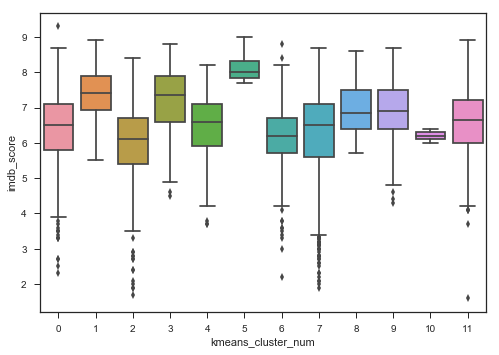

In [100]:
sns.boxplot(x='kmeans_cluster_num', y='imdb_score', data=tmp)

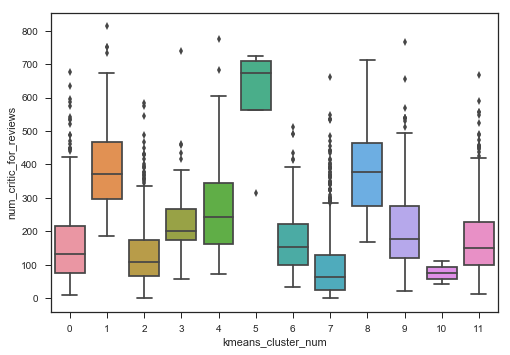

In [101]:
sns.boxplot(x='kmeans_cluster_num', y='num_critic_for_reviews', data=tmp)

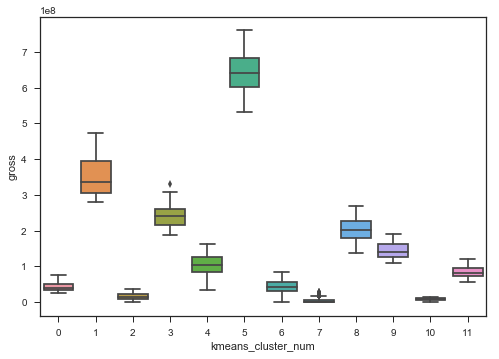

In [105]:
sns.boxplot(x='kmeans_cluster_num', y='gross', data=tmp)

#### Agglomerative Clustering

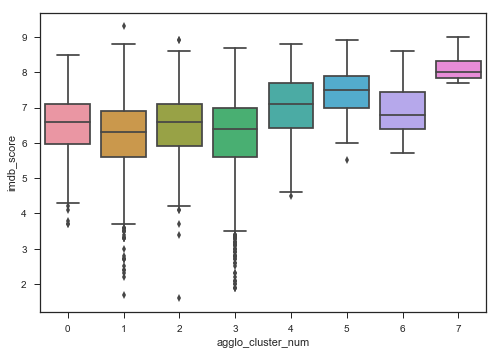

In [103]:
sns.boxplot(x='agglo_cluster_num', y='imdb_score', data=tmp)

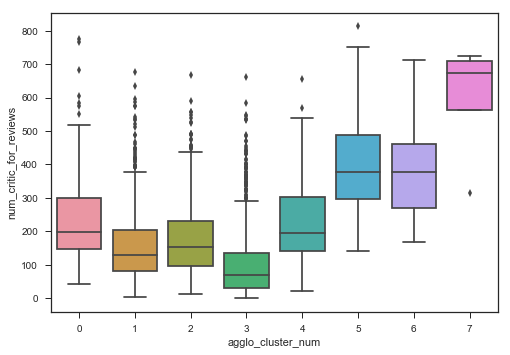

In [104]:
sns.boxplot(x='agglo_cluster_num', y='num_critic_for_reviews', data=tmp)

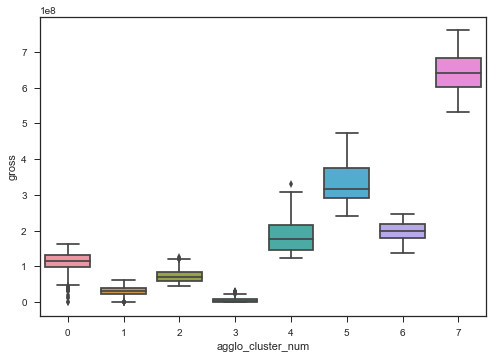

In [106]:
sns.boxplot(x='agglo_cluster_num', y='gross', data=tmp)

### Investigation of each cluster

Even though the Agglomerative Clustering algorithm has larger deviance, but based on what I see in the boxplots, KMeans actually does a better job at differentiating the high score movies from the low score movies.

I just feel maybe 12 clusters are too many, let's investigate the second-best result first and then decide which one to choose as the final clustering result.

In [111]:
# fill in the function to get the second-best result

In [112]:
clust1 = KMeans(n_clusters=8, n_jobs=-1).fit(imdb_train)

In [113]:
tmp = pd.concat([imdb_train[['imdb_score', 'num_critic_for_reviews', 'gross']].copy().reset_index(drop=True), 
                 pd.Series(clust1.labels_, name="kmeans_cluster_num")], axis=1)

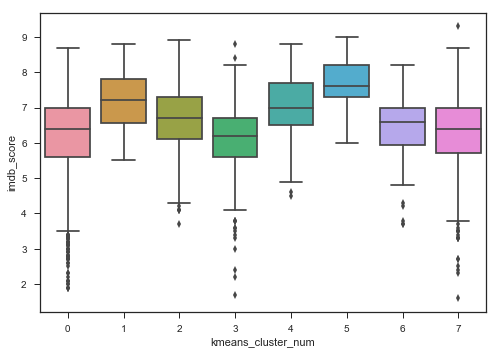

In [114]:
sns.boxplot(x='kmeans_cluster_num', y='imdb_score', data=tmp)

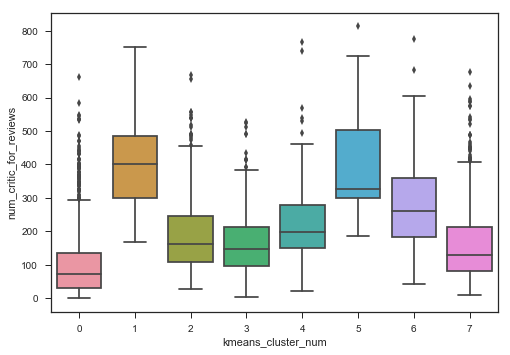

In [115]:
sns.boxplot(x='kmeans_cluster_num', y='num_critic_for_reviews', data=tmp)

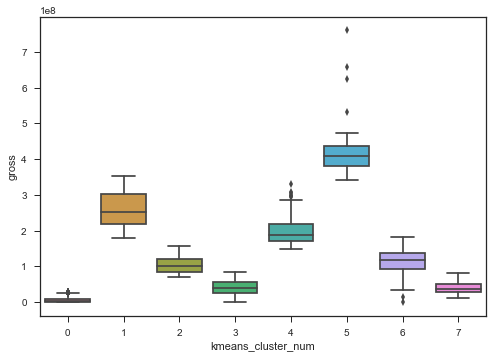

In [116]:
sns.boxplot(x='kmeans_cluster_num', y='gross', data=tmp)

### Choose the best from the candidate models
I still need to see which movies go into which cluster to decide which one is better.

**Candidate models**
1. AgglomerativeClustering(8)
2. KMeans(12)
3. KMeans(8)

In [12]:
tmp = copy.deepcopy(imdb_train)

In [13]:
clust1 = AgglomerativeClustering(n_clusters=8).fit(imdb_train)
tmp['agglo_8_labels'] = clust1.labels_

In [14]:
clust2 = KMeans(n_clusters=12).fit(imdb_train)
tmp['kmeans_12_labels'] = clust2.labels_

In [15]:
clust3 = KMeans(n_clusters=8).fit(imdb_train)
tmp['kmeans_8_labels'] = clust3.labels_

In [16]:
tmp.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,content_rating_PG-13,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X,agglo_8_labels,kmeans_12_labels,kmeans_8_labels
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204.0,4834.0,0.0,3054.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7,10,4
Pirates of the Caribbean: At World's End,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220.0,48350.0,0.0,1238.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,7,3
The Dark Knight Rises,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337.0,106759.0,0.0,2701.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3,4
John Carter,462.0,132.0,475.0,530.0,640.0,73058679.0,212204.0,1873.0,1.0,738.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,1
Spider-Man 3,392.0,156.0,0.0,4000.0,24000.0,336530303.0,383056.0,46055.0,0.0,1902.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,7,3


In [18]:
tmp.loc[tmp['agglo_8_labels'] == tmp.loc['Inception\xc2\xa0']['agglo_8_labels']].index.tolist()
# Pirates of the Caribbean series
# Spider Man series
# Harry Potter series
# The Hobbit series
# Transformers series
# Iron Man series
# The Hunger Games series
# Star Wars series
# The Lord of the Rings series
# Comments: It makes sense to group these series together, but it doesn't make much sense to put movies like Finding Nemo, Frozen
# and Despicable Me also in this group. The style and contents are totally different, which implies that given this codified data,
# the algorithm only classify movies by their popularity. Text model is definitely needed.

["Pirates of the Caribbean: At World's End\xc2\xa0",
 'The Dark Knight Rises\xc2\xa0',
 'Spider-Man 3\xc2\xa0',
 'Harry Potter and the Half-Blood Prince\xc2\xa0',
 "Pirates of the Caribbean: Dead Man's Chest\xc2\xa0",
 'Man of Steel\xc2\xa0',
 'Pirates of the Caribbean: On Stranger Tides\xc2\xa0',
 'The Hobbit: The Battle of the Five Armies\xc2\xa0',
 'The Amazing Spider-Man\xc2\xa0',
 'The Hobbit: The Desolation of Smaug\xc2\xa0',
 'Skyfall\xc2\xa0',
 'Spider-Man 2\xc2\xa0',
 'Iron Man 3\xc2\xa0',
 'Alice in Wonderland\xc2\xa0',
 'Monsters University\xc2\xa0',
 'Transformers: Revenge of the Fallen\xc2\xa0',
 'Toy Story 3\xc2\xa0',
 'Transformers: Dark of the Moon\xc2\xa0',
 'Indiana Jones and the Kingdom of the Crystal Skull\xc2\xa0',
 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe\xc2\xa0',
 'Up\xc2\xa0',
 'Iron Man\xc2\xa0',
 'Iron Man 2\xc2\xa0',
 'Captain America: The Winter Soldier\xc2\xa0',
 'Guardians of the Galaxy\xc2\xa0',
 'Inception\xc2\xa0',
 'The Hobbit: 

In [19]:
tmp.loc[tmp['kmeans_12_labels'] == tmp.loc['Inception\xc2\xa0']['kmeans_12_labels']].index.tolist()
# This cluster looks more diversified that the above result, yet some of the series are still contained in this group.

["Pirates of the Caribbean: At World's End\xc2\xa0",
 'Spider-Man 3\xc2\xa0',
 'Tangled\xc2\xa0',
 'Harry Potter and the Half-Blood Prince\xc2\xa0',
 'Superman Returns\xc2\xa0',
 'Man of Steel\xc2\xa0',
 'Pirates of the Caribbean: On Stranger Tides\xc2\xa0',
 'Men in Black 3\xc2\xa0',
 'The Hobbit: The Battle of the Five Armies\xc2\xa0',
 'The Amazing Spider-Man\xc2\xa0',
 'The Hobbit: The Desolation of Smaug\xc2\xa0',
 'King Kong\xc2\xa0',
 'Skyfall\xc2\xa0',
 'X-Men: The Last Stand\xc2\xa0',
 'Monsters University\xc2\xa0',
 'Transformers: Age of Extinction\xc2\xa0',
 'Oz the Great and Powerful\xc2\xa0',
 'The Amazing Spider-Man 2\xc2\xa0',
 'Cars 2\xc2\xa0',
 'World War Z\xc2\xa0',
 'X-Men: Days of Future Past\xc2\xa0',
 'Star Trek Into Darkness\xc2\xa0',
 'Indiana Jones and the Kingdom of the Crystal Skull\xc2\xa0',
 'Brave\xc2\xa0',
 'WALL\xc2\xb7E\xc2\xa0',
 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe\xc2\xa0',
 'Up\xc2\xa0',
 'Monsters vs. Aliens\xc2\xa0',
 'I

In [20]:
tmp.loc[tmp['kmeans_8_labels'] == tmp.loc['Inception\xc2\xa0']['kmeans_8_labels']].index.tolist()
# Similar results. I should start building text models.

["Pirates of the Caribbean: At World's End\xc2\xa0",
 'Spider-Man 3\xc2\xa0',
 'Tangled\xc2\xa0',
 'Harry Potter and the Half-Blood Prince\xc2\xa0',
 'Superman Returns\xc2\xa0',
 'Man of Steel\xc2\xa0',
 'Pirates of the Caribbean: On Stranger Tides\xc2\xa0',
 'Men in Black 3\xc2\xa0',
 'The Hobbit: The Battle of the Five Armies\xc2\xa0',
 'The Amazing Spider-Man\xc2\xa0',
 'The Hobbit: The Desolation of Smaug\xc2\xa0',
 'King Kong\xc2\xa0',
 'Skyfall\xc2\xa0',
 'Alice in Wonderland\xc2\xa0',
 'X-Men: The Last Stand\xc2\xa0',
 'Monsters University\xc2\xa0',
 'Transformers: Age of Extinction\xc2\xa0',
 'Oz the Great and Powerful\xc2\xa0',
 'The Amazing Spider-Man 2\xc2\xa0',
 'Cars 2\xc2\xa0',
 'World War Z\xc2\xa0',
 'X-Men: Days of Future Past\xc2\xa0',
 'Star Trek Into Darkness\xc2\xa0',
 'Transformers: Dark of the Moon\xc2\xa0',
 'Indiana Jones and the Kingdom of the Crystal Skull\xc2\xa0',
 'Brave\xc2\xa0',
 'WALL\xc2\xb7E\xc2\xa0',
 'The Chronicles of Narnia: The Lion, the Witch an